# **Dataiku Data Scientist Technical Assessment**
### Author : Jules Boistard
### Submission date : January 18th, 2022
___

#### **#2 : Pre-processing and preliminary model selection**

The goal here is to iteratively find the best pre-processing pipeline based on a simple basic machine learning model, adding/removing steps along the way.

This section **does not** aim at finding the best performing model. This will be the focus of the next section ("model selection").

##### **#2.1 : Importing and splitting data**

In [10]:
# Read the train and test files without duplicates and conflicts
# NB : we do not want instance weight for machine learning training
import pandas as pd

train = pd.read_csv("data/train_clean.csv", header=0)
test = pd.read_csv("data/test_clean.csv", header=0)
data = pd.concat([train, test])

# Split datasets into features set and target variable
# Note : target classes "-50k" and ">50k" will respectively be labelled 0 and 1
X_train_raw = train.iloc[:, :-2]
X_test_raw = test.iloc[:, :-2]
y_train = train.iloc[:, -2].map(lambda s: 0 if "-" in s else 1)
y_test = test.iloc[:, -2].map(lambda s: 0 if "-" in s else 1)

##### **#2.2 : Pre processing**

Our first pre-processing pipeline will consist in 4 basic steps :
1. Drop columns with ~50% NaN Values (see part 1 : EDA)
2. Impute NaN values with most frequent class for other columns wit missing values (see part 1 : EDA)
3. Encode our remaining categorical features with one hot encoding
4. Perform standard scaling for our numerical features

In [11]:
# Let us first define different sets of features
cols_to_drop = ["migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "migration prev res in sunbelt"]
num_cols = ["age", "wage per hour", "capital gains", "capital losses", "dividends from stocks", "weeks worked in year"] # "num persons worked for employer" is removed because of mapping
cat_cols = list(set(X_train_raw.columns).difference(set(num_cols)).difference(set(cols_to_drop)))

In [12]:
# Drop useless columns
X_train = X_train_raw.drop(cols_to_drop, axis=1)
X_test = X_test_raw.drop(cols_to_drop, axis=1)

In [13]:
# Imputer for missing value with most frequent category (numerical features don't have missing values)
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent").fit(pd.concat([X_train, X_test]))

X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [14]:
# One hot encoding for categorical variables
# Note : we will drop the 0 / Not in universe category for each variable if it exists, othewise the first one by default, to avoid multicollinearity
from sklearn.preprocessing import OneHotEncoder

drop_cat = []
for col in cat_cols:
    cat_values = list(X_train[col].unique())    
    if 0 in cat_values:
        drop_cat.append(0)
    elif "Not in universe" in cat_values:
        drop_cat.append("Not in universe")
    else:
        drop_cat.append(cat_values[0])

encoder = OneHotEncoder(drop=drop_cat, sparse=False, dtype="int32", handle_unknown="ignore").fit(pd.concat([X_train[cat_cols], X_test[cat_cols]]))
new_cat_cols = encoder.get_feature_names_out()

X_train_onehot = pd.DataFrame(encoder.transform(X_train[cat_cols]), columns=new_cat_cols)
X_test_onehot = pd.DataFrame(encoder.transform(X_test[cat_cols]), columns=new_cat_cols)

X_train = pd.concat([X_train_onehot, X_train[num_cols]], axis=1)
X_test = pd.concat([X_test_onehot, X_test[num_cols]], axis=1)

In [15]:
# Scale numerical columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(pd.concat([X_train[num_cols], X_test[num_cols]]))
col_names = scaler.get_feature_names_out()

X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=col_names)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=col_names)

X_train = pd.concat([X_train_scaled, X_train[new_cat_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[new_cat_cols]], axis=1)

##### **#2.3 : Baseline models**

To begin with, we will compare two very basic models, on which we will perform minimal pre-processing :
- One linear : a logistic regression model
- One non linear : a decision tree

In [16]:
# Define evaluation procedure
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def evaluate_model(model, X_train, y_train, X_test, y_test, curves=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred, target_names=["Low income (<50k)", "High income (>50k)"], digits=4))

    if curves:
        N, train_score, val_score = learning_curve(model, X_train, y_train, scoring="f1_macro")
        plt.figure()
        plt.plot(N, train_score.mean(axis=1), label="train score")
        plt.plot(N, val_score.mean(axis=1), label="val score")
        plt.legend()


**Important** : we do not value one of the 2 target classes more than the other. In other words, good predictions are equally important for the "low income" and "high income" classes. On the other hand, accuracy will not do because of class imbalance (~94%/6%). We can therefore choose the **macro averaged f1-score** as our performance metric.

                    precision    recall  f1-score   support

 Low income (<50k)     0.9870    0.8435    0.9096     72669
High income (>50k)     0.3199    0.8689    0.4677      6157

          accuracy                         0.8455     78826
         macro avg     0.6535    0.8562    0.6886     78826
      weighted avg     0.9349    0.8455    0.8751     78826



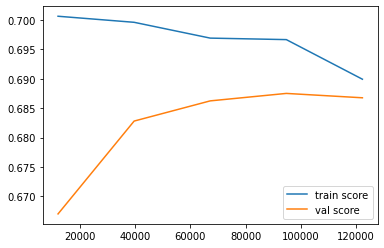

In [17]:
# Building and evaluating a baseline logistic regression model
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)
evaluate_model(lr_clf, X_train, y_train, X_test, y_test, curves=True)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9576    0.9524    0.9549     72669
High income (>50k)     0.4715    0.5017    0.4862      6157

          accuracy                         0.9172     78826
         macro avg     0.7145    0.7270    0.7205     78826
      weighted avg     0.9196    0.9172    0.9183     78826



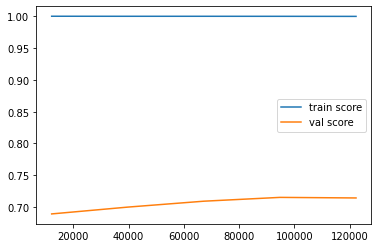

In [18]:
# Building and evaluating a baseline decision tree
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(criterion="entropy", class_weight="balanced", random_state=42)
evaluate_model(dt_clf, X_train, y_train, X_test, y_test, curves=True)

A couple things worth noting :
- The **decision tree performs better** than the logistic regression model. We will however continue to compare the both of them throughout the next steps.
- Depending on the context, we could favor one based on individual f1, recall or sensitivity scores for one of the two classes.
- Overall, there is room for improvement. While the f1 score is not too bad on the majority class (low income) it is, as could be expected, quite poor for the minority class (high income).

To adress the issue of underfitting, we will try the following pre-processing operations :
- Perform over-sampling to increase the representation of the minority class
- Perform some feature engineering

Before going any further, let us take a look at feature conctribution in both models

In [19]:
feature_contrib = pd.concat([
    pd.DataFrame(data=lr_clf.coef_.flatten(), index=X_train.columns, columns=["log reg coef"]),
    pd.DataFrame(data=dt_clf.feature_importances_, index=X_train.columns, columns=["tree contrib"])
], axis=1)
feature_contrib["log reg coef abs"] = abs(feature_contrib["log reg coef"])

In [20]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print("===== Top contributing features for log reg =====")
feature_contrib.sort_values("log reg coef abs", ascending=False).head(10)

===== Top contributing features for log reg =====


,log reg coef,tree contrib,log reg coef abs
education_Doctorate degree(PhD EdD),2.307,0.004,2.307
country of birth self_Nicaragua,-2.038,0.000,2.038
country of birth father_Guatemala,-2.009,0.000,2.009
education_Prof school degree (MD DDS DVM LLB JD),1.895,0.003,1.895
tax filer stat_Joint both under 65,1.891,0.003,1.891
country of birth self_Scotland,1.767,0.000,1.767
country of birth self_Guatemala,1.764,0.000,1.764
education_Masters degree(MA MS MEng MEd MSW MBA),1.673,0.009,1.673
tax filer stat_Head of household,1.499,0.002,1.499
education_Less than 1st grade,-1.479,0.000,1.479


In [21]:
print("===== Top contributing features for decision tree =====")
feature_contrib.sort_values("tree contrib", ascending=False).head(10)

===== Top contributing features for decision tree =====


,log reg coef,tree contrib,log reg coef abs
weeks worked in year,0.913,0.187,0.913
age,0.632,0.136,0.632
dividends from stocks,0.497,0.110,0.497
sex_Female,-1.106,0.047,1.106
capital gains,0.837,0.045,0.837
major occupation code_Professional specialty,0.810,0.023,0.810
major occupation code_Executive admin and managerial,0.480,0.019,0.480
capital losses,0.198,0.016,0.198
education_Bachelors degree(BA AB BS),1.062,0.012,1.062
num persons worked for employer_6,0.521,0.011,0.521


We can spot some interesting things that corroborate some of the insights from EDA (see part 1) :
- 3 of the highest academic degrees were decisive for the "high income" class in the log reg model (positive coef)
- In decision trees, the feature that gives the maximum information gain is the number of weeks worked during the year.
- The "women feature" skews the log reg model towards the "low income" class (negative coef)

##### **#2.3 : Over sampling**

Let us try and perform over sampling through a SMOTE algorithm (Synthetic Minority Oversampling TEchnique). The goal is to artificially create observations for the minority class "in between" real observations from the same class in the feature space, up until the two classes have an equal number of observations

In [22]:
# Try and perform over sampling to balance classes out
from imblearn.over_sampling import SMOTE

X_train_resampled, y_train_resampled = SMOTE(sampling_strategy="auto", random_state=42).fit_resample(X_train, y_train)

In [87]:
# Evaluate with log reg model
evaluate_model(lr_clf, X_train_resampled, y_train_resampled, X_test, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9643    0.9447    0.9544     72669
High income (>50k)     0.4736    0.5873    0.5244      6157

          accuracy                         0.9168     78826
         macro avg     0.7190    0.7660    0.7394     78826
      weighted avg     0.9260    0.9168    0.9208     78826



In [128]:
# Same with decision tree
evaluate_model(dt_clf, X_train_resampled, y_train_resampled, X_test, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9592    0.9384    0.9487     72669
High income (>50k)     0.4209    0.5283    0.4685      6157

          accuracy                         0.9064     78826
         macro avg     0.6900    0.7334    0.7086     78826
      weighted avg     0.9171    0.9064    0.9112     78826



We can observe two different results :
- Oversampling greatly improved the average f1 score of our logistic regression model (we gained 5%)
- The same operation dit **not** improve the performance of our decision tree (we lost a little less than 1%)

##### **#2.4 : Feature engineering**

We have tried adding observations. Let us now try to add features.

Since we want to preserve some degree of "explainability" in our model, we will not make us of feature engineering algorithm such as polynomial features.

However, one interesting step would be to compute our own features. This usually requires domain expertise and, often, gathering extra data. To work with what we have, we can try for example :
- To compute an estimate of total earnings based on wage per hour, weeks worked in year and additional incomes such as capital gains and dividends from stocks
- To replace "num persons worked for employer" category numbers by the segment mean, according to documentation
- To compute an estimate of tax rate based on our earnings estimate and tax filling status

In [104]:
# Average working week is 34.6 hours in the US according to Buereau of Labor Statistics
def estimate_earnings(hourly_wage, worked_weeks, capital_gains, capital_losses, dividends, average_hours_in_working_week_us=34.6):
    return (
        (hourly_wage * worked_weeks * average_hours_in_working_week_us) + capital_gains + dividends - capital_losses
    )

In [91]:
# Mean segment company sizes, from doc
segment_mean_company_size = {
    0: 0,
    1: (0 + 10)/2,
    2: (10 + 24)/2,
    3: (25 + 99)/2,
    4: (100 + 499)/2,
    5: (500 + 999)/2,
    6: 2000, # Arbitrary
}

In [114]:
'''  Tax rates from year 1995 found here : https://taxfoundation.org/historical-income-tax-rates-brackets/

Married Filing Jointly 	Married Filing Separately 	Single Filer 	Head of Household

15.0% 	> 	$0 	        15.0% 	> 	$0 	        15.0% 	> 	$0 	        15.0% 	> 	$0
28.0% 	> 	$39,000 	28.0% 	> 	$19,500 	28.0% 	> 	$23,350 	28.0% 	> 	$31,250 	 
31.0% 	> 	$94,250 	31.0% 	> 	$47,125 	31.0% 	> 	$56,550 	31.0% 	> 	$80,750 	 
36.0% 	> 	$143,600 	36.0% 	> 	$71,800 	36.0% 	> 	$117,950 	36.0% 	> 	$130,800 	 
39.6% 	> 	$256,500 	39.6% 	> 	$128,250 	39.6% 	> 	$256,500 	39.6% 	> 	$256,500 
'''
import numpy as np

def estimate_tax_amount(tax_fill_stat, marital_stat, earnings):

    tax_rates = [0.15, 0.28, 0.31, 0.36, 0.396]
    
    if tax_fill_stat == "Nonfiler":
        return 0
    
    elif tax_fill_stat == "Single":
        if "Married" in marital_stat: # Married filling separately
            earning_brackets = [0, 19500, 47125, 71800, 128250, np.inf]

        else : # Single filling
            earning_brackets = [0, 23350, 56550, 117950, 256500, np.inf]

    elif tax_fill_stat == "Head of household":
        earning_brackets = [0, 31250, 80750, 130800, 256500, np.inf]

    else: # Joint filling
        earning_brackets = [0, 39000, 94250, 143600, 256500, np.inf]

    amounts_in_brackets= np.clip(earnings, earning_brackets[:-1], earning_brackets[1:]) - earning_brackets[:-1]
    tax_amount_estimate = (np.array(tax_rates) * amounts_in_brackets).sum()

    return tax_amount_estimate

In [115]:
def new_features(X):

    X_ = X.copy()
    
    X_["earnings estimate"] = X_.apply(lambda row: estimate_earnings(
        hourly_wage=row["wage per hour"]/100, # Note : according to doc, wage per hour has a 2 decimal implied
        worked_weeks=row["weeks worked in year"],
        capital_gains=row["capital gains"],
        capital_losses=row["capital losses"],
        dividends=row["dividends from stocks"]
    ), axis=1)

    X_["nb of employees in company estimate"] = X_["num persons worked for employer"].map(segment_mean_company_size)

    X_["tax amount estimate"] = X_.apply(lambda row: estimate_tax_amount(
        tax_fill_stat=row["tax filer stat"],
        marital_stat=row["marital stat"],
        earnings=row["earnings estimate"]
    ), axis=1) 

    return X_[["earnings estimate", "nb of employees in company estimate", "tax amount estimate"]]

In [123]:
# Add features in datasets and scale them
X_train_new_features = new_features(X_train_raw)
X_test_new_features = new_features(X_test_raw)

In [124]:
scaler = StandardScaler().fit(pd.concat([X_train_new_features, X_test_new_features]))
col_names = scaler.get_feature_names_out()

X_train_new_features = pd.concat([X_train, pd.DataFrame(scaler.transform(X_train_new_features), columns=col_names)], axis=1)
X_test_new_features = pd.concat([X_test, pd.DataFrame(scaler.transform(X_test_new_features), columns=col_names)], axis=1)

In [127]:
# Try our new features with the log reg model
evaluate_model(lr_clf, X_train_new_features, y_train, X_test_new_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9870    0.8434    0.9096     72669
High income (>50k)     0.3199    0.8691    0.4676      6157

          accuracy                         0.8454     78826
         macro avg     0.6534    0.8563    0.6886     78826
      weighted avg     0.9349    0.8454    0.8751     78826



                    precision    recall  f1-score   support

 Low income (<50k)     0.9578    0.9528    0.9553     72669
High income (>50k)     0.4748    0.5041    0.4890      6157

          accuracy                         0.9177     78826
         macro avg     0.7163    0.7285    0.7222     78826
      weighted avg     0.9200    0.9177    0.9188     78826



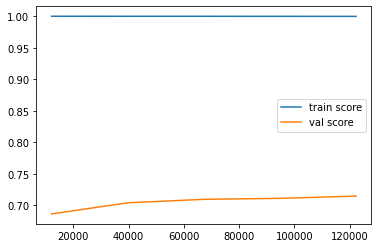

In [132]:
# Same with decision tree
evaluate_model(dt_clf, X_train_new_features, y_train, X_test_new_features, y_test, curves=True)

This couple of extra features did not quite do the trick. They marginally improved f1 score on the decision tree, but not on the log reg model.

Note that this is a very important part of data modelling. As such, feature engineering would probably require a fair bit of extra investigation.

Before diving into the next part, let us check whether combining SMOTE with our extra features further improves log reg model performance or not

In [134]:
X_train_resampled_new_features, y_train_resampled_new_features = SMOTE(sampling_strategy="auto", random_state=42).fit_resample(X_train_new_features, y_train)
evaluate_model(lr_clf, X_train_resampled_new_features, y_train_resampled_new_features, X_test_new_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9640    0.9452    0.9545     72669
High income (>50k)     0.4741    0.5832    0.5231      6157

          accuracy                         0.9169     78826
         macro avg     0.7191    0.7642    0.7388     78826
      weighted avg     0.9257    0.9169    0.9208     78826



This is not the case, therefore we will completely abandon extra features for non-tree based models

##### **#2.5 : More complex models**

While we found a couple of preprocessing tricks to improve model performance, there is still room for improvement. Before diving into fine-tuning, we can try out a couple of different models, a little bit more elaborate than our two baselines models.

In [135]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(class_weight="balanced", random_state=42)

evaluate_model(rf_clf, X_train_new_features, y_train, X_test_new_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9518    0.9872    0.9692     72669
High income (>50k)     0.7308    0.4106    0.5258      6157

          accuracy                         0.9422     78826
         macro avg     0.8413    0.6989    0.7475     78826
      weighted avg     0.9346    0.9422    0.9346     78826



In [136]:
# Gradient boosted trees
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42)

evaluate_model(gb_clf, X_train_new_features, y_train, X_test_new_features, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9516    0.9894    0.9701     72669
High income (>50k)     0.7636    0.4056    0.5298      6157

          accuracy                         0.9438     78826
         macro avg     0.8576    0.6975    0.7499     78826
      weighted avg     0.9369    0.9438    0.9357     78826



In [137]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="log", class_weight="balanced", random_state=42)

evaluate_model(sgd_clf, X_train_resampled, y_train_resampled, X_test, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9662    0.9401    0.9530     72669
High income (>50k)     0.4640    0.6120    0.5278      6157

          accuracy                         0.9145     78826
         macro avg     0.7151    0.7760    0.7404     78826
      weighted avg     0.9270    0.9145    0.9198     78826



Without any fine-tuning, we can already see that all of these models already outperform our two baselines models.

They are actually pretty close to each other in terms of performance.

In the next section, we will compare them with different sets of hyperparameters to find the best predictive model.

##### **#2.6 : A note on feature selection**

Before we dive into fine tuning, it is worth noting that feature selection can sometimes improve model performance, getting rid of noise and avoiding dimensionality issues.

Since we do not have a major problem of overfitting, we will not perform feature selection here.

There is an example of feature selection for the SGD classifier below, yielding a lower f1 score than the "raw" equivalent classifier.

In [138]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

sgd_clf_with_fs = Pipeline(steps=[
    ("feature_selec", SelectFromModel(
        estimator=LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42),
        threshold="median"
    )),
    ("classifier", SGDClassifier(loss="log", class_weight="balanced", random_state=42))
])

evaluate_model(sgd_clf_with_fs, X_train_resampled, y_train_resampled, X_test, y_test, curves=False)

                    precision    recall  f1-score   support

 Low income (<50k)     0.9645    0.9263    0.9450     72669
High income (>50k)     0.4070    0.5970    0.4840      6157

          accuracy                         0.9006     78826
         macro avg     0.6857    0.7617    0.7145     78826
      weighted avg     0.9209    0.9006    0.9090     78826



___
#### **#3 : Fine tuning and model assessment**

In this final section, we will perform grid search combined with cross validation to find the best set of hyper parameters for each of our three models, which are :
- Random Forest
- Gradient Boosting
- Stochastic Gradient Descent

We will then pick the overall best performing model for further analysis

In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

##### **#3.1 : Random Forest**

In [ ]:
# Random Forest
'''rf_params = {
    "n_estimators": [500, 1000, 2000],
    "criterion" : ["entropy"],
    "class_weight": ["balanced"]
}

rf_gscsv = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=rf_params,
    scoring="f1_macro",
    verbose=1
)

rf_gscsv = rf_gscsv.fit(X_train_new_features, y_train)'''

In [ ]:
print("===== Random Forest Best Model ====")

print("f1-score validation : ", round(rf_gscsv.best_score_, 4), " with ", rf_gscsv.best_params_)

y_pred = rf_gscsv.best_estimator_.predict(X_test_new_features)
score = f1_score(y_test, y_pred, average="macro")
print("f1-score on test set : ", round(score, 4))

print(classification_report(y_test, y_pred, target_names=["Low income (<50k)", "High income (>50k)"], digits=4))

===== Random Forest Best Model ====
f1-score validation :  0.7494  with  {'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 2000}
f1-score on test set :  0.7552
                    precision    recall  f1-score   support

 Low income (<50k)     0.9536    0.9855    0.9693     72669
High income (>50k)     0.7177    0.4343    0.5411      6157

          accuracy                         0.9425     78826
         macro avg     0.8356    0.7099    0.7552     78826
      weighted avg     0.9352    0.9425    0.9359     78826



##### **#3.2 : Gradient Boosting**

In [ ]:
'''gb_params = {
    "n_estimators": [100, 500],
    "learning_rate": [0.1],
    "max_depth": [3, 5, 10],
}

gb_gscsv = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid=gb_params,
    scoring="f1_macro",
    verbose=1,
    cv=3
)

gb_gscsv = gb_gscsv.fit(X_train_new_features, y_train)'''

In [ ]:
print("===== Gradient Boosting Best Model ====")

print("f1-score validation : ", round(gb_gscsv.best_score_, 4), " with ", gb_gscsv.best_params_)

y_pred = gb_gscsv.best_estimator_.predict(X_test_new_features)
score = f1_score(y_test, y_pred, average="macro")
print("f1-score on test set : ", round(score, 4))

print(classification_report(y_test, y_pred, target_names=["Low income (<50k)", "High income (>50k)"], digits=4))

===== Gradient Boosting Best Model ====
f1-score validation :  0.7795  with  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
f1-score on test set :  0.7638
                    precision    recall  f1-score   support

 Low income (<50k)     0.9562    0.9821    0.9690     72669
High income (>50k)     0.6893    0.4695    0.5586      6157

          accuracy                         0.9420     78826
         macro avg     0.8228    0.7258    0.7638     78826
      weighted avg     0.9354    0.9420    0.9369     78826



##### **#3.3 : SGD**

In [ ]:
'''sgd_params = {
    "alpha": [0.0001, 0.001, 0.01],
    "penalty": ["l1", "l2"],
    "loss": ["log"],
    "class_weight": ["balanced"],
    "max_iter": [2000]
}

sgd_gscsv = GridSearchCV(
    estimator=SGDClassifier(),
    param_grid=sgd_params,
    scoring="f1_macro",
    verbose=1,
    cv=3
)

sgd_gscsv = sgd_gscsv.fit(X_train_resampled, y_train_resampled)'''

In [143]:
print("===== SGD Best Model ====")

print("f1-score validation : ", round(sgd_gscsv.best_score_, 4), " with ", sgd_gscsv.best_params_)

y_pred = sgd_gscsv.best_estimator_.predict(X_test)
score = f1_score(y_test, y_pred, average="macro")
print("f1-score on test set : ", round(score, 4))

print(classification_report(y_test, y_pred, target_names=["Low income (<50k)", "High income (>50k)"], digits=4))

===== SGD Best Model ====
f1-score validation :  0.925  with  {'alpha': 0.0001, 'class_weight': 'balanced', 'loss': 'log', 'max_iter': 2000, 'penalty': 'l2'}
f1-score on test set :  0.7328
                    precision    recall  f1-score   support

 Low income (<50k)     0.9688    0.9276    0.9478     72669
High income (>50k)     0.4313    0.6477    0.5178      6157

          accuracy                         0.9058     78826
         macro avg     0.7001    0.7877    0.7328     78826
      weighted avg     0.9268    0.9058    0.9142     78826



##### **#3.4 : Best model**

After tuning and testing, we can find the best performing model to be **Gradient Boosting**, a tree-based model, with an average f1-score of **76,38%**

The score is pretty low, especially on the "high income" class (minority class). While we managed to improve precision on this class by quite a bit, recall is still low. 

Before concluding, let us take a final look at feature importance for our best fitted model

In [154]:
feature_imp = pd.DataFrame(data=gb_gscsv.best_estimator_.feature_importances_, index=X_train_new_features.columns, columns=["score"])
feature_imp.sort_values("score", ascending=False).head(20)

,score
capital gains,0.237
dividends from stocks,0.128
weeks worked in year,0.098
sex_Female,0.095
capital losses,0.050
major occupation code_Executive admin and managerial,0.046
age,0.046
major occupation code_Professional specialty,0.039
education_Prof school degree (MD DDS DVM LLB JD),0.033
education_Masters degree(MA MS MEng MEd MSW MBA),0.030


___
#### **Future improvements**

- Collect **additional observations** of the minority class to resolve balancing issue.
- Perform more **feature engineering** with domain expertise and gathering of extra data if necessary
- Take a deeper dive into **feature importance**, for instance by computing Shapley values after modelling
- Further investigate **dependencies in-between features** to avoid multicollinearity